In [2]:
import numpy as np
import matplotlib.pyplot as plt

The purpose of this notebook is to provide a walkthrough of my thought process behind my decisions/code. In this notebook, I will use MCMCs and data from the Planck Public Release II to constrain various cosmological parameters. 

### Importing pypico

Pypico (Parameters for the Impatient Cosmologist) is a package that computes the CMB power spectra and matter transfer functions at a much quicker rate versus other packages (such as CAMB). It does this by interpolating through "training data", which for the purpose of this project, will be sufficient enough. The test data was obtained from [https://github.com/marius311/pypico-trainer/releases](here). 

In [5]:
import pypico
path_to_data = '/home/mattias/Desktop/McGill/W2022/PHYS321-Final-Project/data/jcset_py3.dat'
pico = pypico.load_pico(path_to_data)

In [6]:
# This data will accept the following input cosmological parameters: 
pico.inputs()

['As', 'ns', 'tau', 'ombh2', 'omch2', 'H0', 'omk']

In [7]:
# The outputted quantity can be obtained by calling
pico.outputs()

['cl_TT']

In [8]:
# Finally, to obtain the result, we define a dictionary of parameters with keys for each input
# To get a sample set of inputs, we can call
pico.example_inputs()

{'As': 2.08e-09,
 'ns': 0.97,
 'tau': 0.055,
 'ombh2': 0.0225,
 'omch2': 0.117,
 'H0': 50,
 'omk': -0.05,
 'pivot_scalar': 0.05}

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
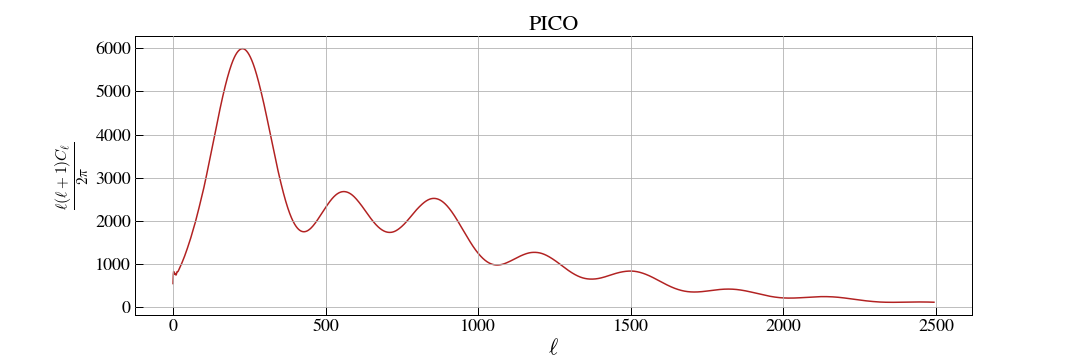

In [9]:
# Now we can get our results 
As, ns, tau, ombh2, omch2, H0, omk = 2e-9, 0.97, 0.055, 0.023, 0.1, 60, -0.05
inputs = {'As':As, 'ns':ns, 'tau':tau, 'ombh2':ombh2, 'omch2':omch2, 'H0':H0}
output = pico.get(**inputs, omk=0)
dl_TT = output['dl_TT']
npts_simulation = len(dl_TT)

# Plot
plt.figure(figsize=(15,5))
plt.plot(dl_TT, color='firebrick')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\frac{\ell(\ell +1)C_\ell}{2\pi}$')
plt.grid()
plt.title('PICO')
plt.show()


In [7]:
print(pypico)

<module 'pypico' from '/home/mattias/anaconda3/envs/main_env/lib/python3.9/site-packages/pypico/__init__.py'>


### Loading in the Planck Spectrum

In [10]:
planck = np.loadtxt('data/COM_PowerSpect_CMB-TT-full_R3.01.txt', skiprows = 1)
spectrum = planck[:,1]
errors = 0.5*(planck[:,2] + planck[:,3])
npts = len(spectrum)
npars = 6

# Shorten planck to match pico data
spectrum = spectrum[0:npts_simulation]
errors = errors[0:npts_simulation]

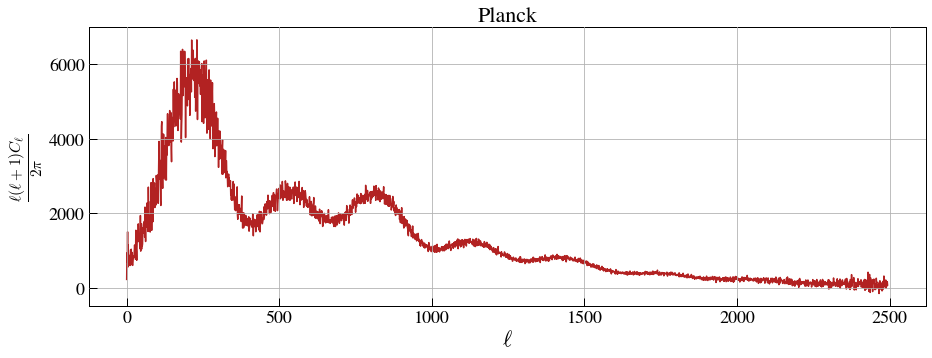

In [9]:
# Plot
plt.figure(figsize=(15,5))
plt.plot(spectrum, color='firebrick')
plt.xlabel(r'$\ell$')
plt.title('Planck')
plt.ylabel(r'$\frac{\ell(\ell +1)C_\ell}{2\pi}$')
plt.grid()
plt.show()


## MCMC #1: Gaussian Errorbars

The parameters we are interested in determing are the following: $A_s, n_s, \tau, \Omega_bh^2, \Omega_ch^2, H_0$. As an intial attempt, we'll assume Gaussian errors on all of the parameters and uniform priors on all values. The likelihood is given by: 
\begin{equation}
p(y_i|A_s, n_s, \tau, \Omega_bh^2, \Omega_ch^2, H_0) = \prod_i^N \frac{\text{exp}\left[\frac{-[y_i - f(x,A_s, n_s, \tau, \Omega_bh^2, \Omega_ch^2, H_0) }{2\sigma_i^2}\right]}{\sqrt{2\pi\sigma_i^2}}
\end{equation}

In [24]:
# Define our pico emulator 
pico = pypico.load_pico(path_to_data)

# Let's combine this into a single function so we can use it later 
def get_spectrum(pars):
    '''
    Computes the power spectrum for a given set of parameters. 
    
    Parameters:
    -----------
    pars: dictionary 
        Dictionary containing input parameters as keys and value as value. The following parameters must be specified: 
            1. As
            2. ns
            3. tau
            4. omch2
            5. ombh2
            6. omk
            7. H0
    '''
    # Get spectrum (output is a dictionary)
    spec_dict = pico.get(**pars, omk=0)
    dl_TT = spec_dict['dl_TT']
    
    return dl_TT

def log_likelihood(params, y, yerr):
    
    As, ns, tau, ombh2, omch2, H0 = params
    
    temp_dict = {'As':As, 'ns':ns, 'tau':tau, 'ombh2':ombh2, 'omch2':omch2, 'H0':H0}
    
    try: 
        pico.get(**temp_dict, omk = 0)
    except: 
        return -np.inf
    
    else: 
        # Get our model y values
        model = get_spectrum(temp_dict)

        # Get variance 
        sigma2 = yerr ** 2

        return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [34]:
import emcee
num_iter = 10000
ndim = 6
nwalkers = 50
#initial_pos = np.array([2e-9, 0.97, 0.055, 0.023, 0.1, 60]) + 1e-12*np.random.randn(nwalkers, ndim)

initial_pos = np.empty((nwalkers, ndim))

As_guess = 2e-9 + 1e-11*np.random.randn(nwalkers)
ns_guess = 0.97 + 0.001*np.random.randn(nwalkers)
tau_guess = 0.055 + 0.0001*np.random.randn(nwalkers)
ombh2_guess = 0.023 + 0.0001*np.random.randn(nwalkers)
omch2_guess = 0.1 + 0.001*np.random.randn(nwalkers)
H0_guess = 60 + 1*np.random.randn(nwalkers)

initial_pos[:,0] = As_guess
initial_pos[:,1] = ns_guess
initial_pos[:,2] = tau_guess
initial_pos[:,3] = ombh2_guess
initial_pos[:,4] = omch2_guess
initial_pos[:,5] = H0_guess


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(spectrum, errors))
sampler.run_mcmc(initial_pos, num_iter, progress=True);

samples = sampler.get_chain()


100%|█████████████████████████████████████| 10000/10000 [08:43<00:00, 19.09it/s]


In [35]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

# Save data to disk for future analysis
path = '/home/mattias/Desktop/McGill/W2022/PHYS321-Final-Project/data/chains_v4.npy'
np.save(path, flat_samples)

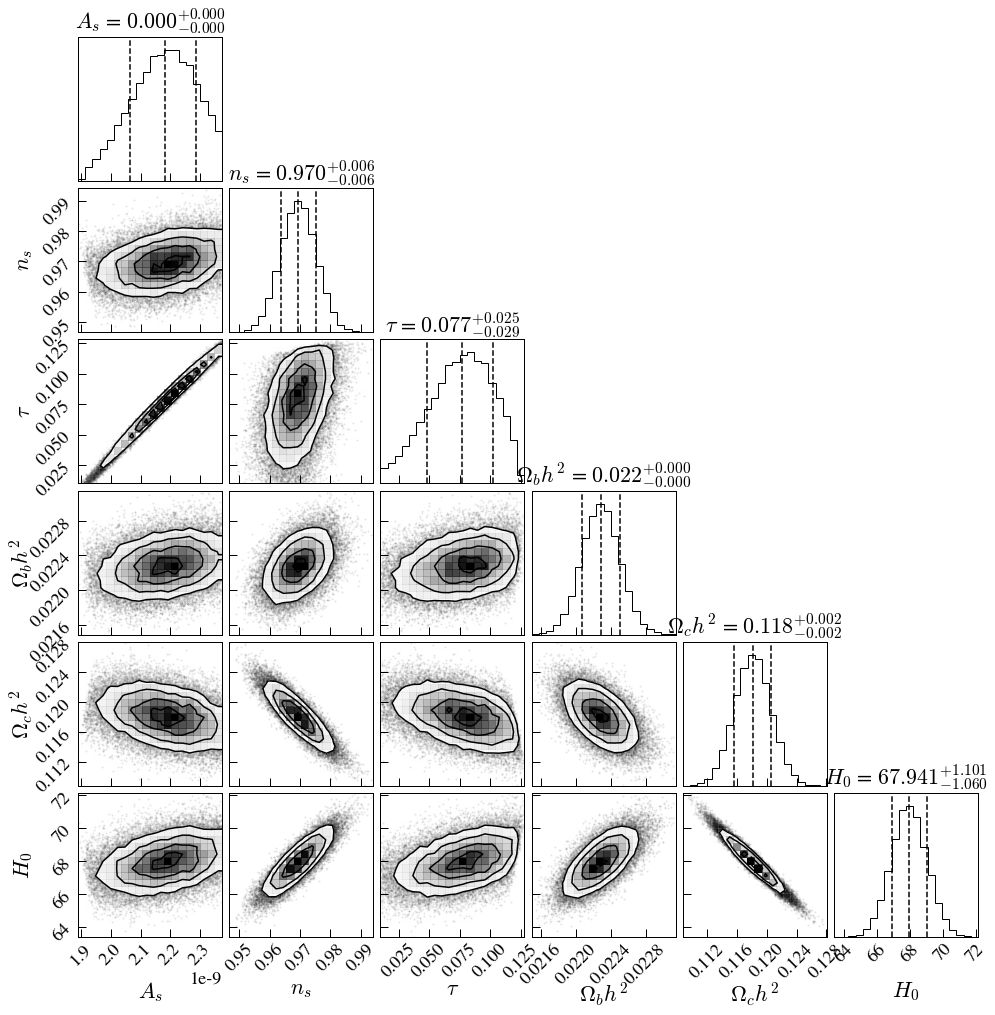

In [36]:
# Load in data 
path = '/home/mattias/Desktop/McGill/W2022/PHYS321-Final-Project/data/chains_v4.npy'

%matplotlib inline
flat_samples_load = np.load(path)

import corner
labels = [r'$A_s$', r'$n_s$', r'$\tau$', r'$\Omega_bh^2$', r'$\Omega_ch^2$', r'$H_0$']
fig = corner.corner(flat_samples_load, labels=labels, show_titles=True,title_fmt='.3f', quantiles=[0.16, 0.5, 0.84]);


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
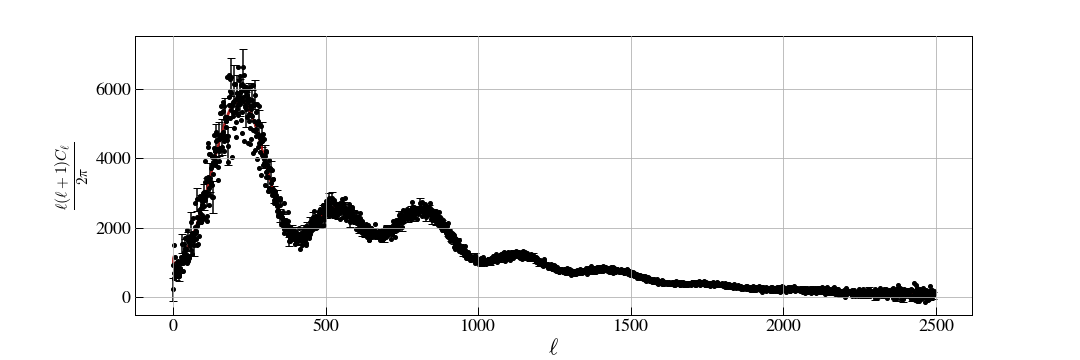

In [37]:
# Plot random selection of parameters 
%matplotlib widget
inds = np.random.randint(len(flat_samples_load), size=100)
f, ax = plt.subplots(figsize=(15,5))
l = np.arange(0,len(spectrum))
ax.errorbar(l, spectrum, yerr=errors,errorevery=10, linestyle = 'None',capsize=4, marker ='.', color='black', ms=8)
for ind in inds:
    As, ns, tau, ombh2, omch2, H0 = flat_samples_load[ind]
    temp_dict = {'As':As, 'ns':ns, 'tau':tau, 'ombh2':ombh2, 'omch2':omch2, 'H0':H0}
    yfit = get_spectrum(temp_dict)
    ax.plot(yfit, alpha=0.05, color='firebrick')

ax.grid()
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\frac{\ell(\ell +1)C_\ell}{2\pi}$')
plt.show()
